In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../fuzzy-tools') # or just install the module

In [2]:
from fuzzytools.files import search_for_filedirs
from lchandler import _C

root_folder = '../../surveys-save'
filedirs = search_for_filedirs(root_folder, fext=_C.EXT_RAW_LIGHTCURVE)

────────────────────────────────────────────────────────────────────────────────────────────────────
found filedirs: (../../surveys-save)
(0) - ../../surveys-save/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds - 1.723[mbs]
(1) - ../../surveys-save/wiib/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds - 1.723[mbs]
(2) - ../../surveys-save/b/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds - 1.711[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────
filedirs after searching with filters: (../../surveys-save)
(0) - ../../surveys-save/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds - 1.723[mbs]
(1) - ../../surveys-save/wiib/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds - 1.723[mbs]
(2) - ../../surveys-save/b/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds - 1.711[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────


In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from fuzzytools.progress_bars import ProgressBar
from fuzzytools.files import load_pickle, save_pickle
from fuzzytools.files import get_dict_from_filedir

filedir = f'../../surveys-save/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.ralcds'
filedict = get_dict_from_filedir(filedir)
root_folder = filedict['_rootdir']
cfilename = filedict['_cfilename']
survey = filedict['survey']
lcdataset = load_pickle(filedir)
print(lcdataset)

LCDataset:
[outliers; samples 4]
(.) obs_samples=289; min_len=14; max_dur=408.0[days]; dur(p50)=222.1[days]; cadence(p50)=0.9[days]
(g) obs_samples=144; min_len=6; tmax=44.923828125; max_dur=408.0 [days]; dur(p50)=222.0 [days]; cadence(p50)=1.9 [days]
(r) obs_samples=145; min_len=8; tmax=212.09375; max_dur=376.0 [days]; dur(p50)=220.4 [days]; cadence(p50)=2.0 [days]
   |██      | SLSN - 1/4 (25.00%)
   |████    | SNII* - 2/4 (50.00%)
   |██      | SNIa - 1/4 (25.00%)
   |        | SNIbc - 0/4 (0.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint; samples 0]
empty lcset
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw; samples 1,994]
(.) obs_samples=54,685; min_len=6; max_dur=538.8[days]; dur(p50)=52.9[days]; cadence(p50)=1.0[days]
(g) obs_samples=24,132; min_len=0; tmax=10.99609375; max_dur=538.8 [days]; dur(p50)=39.0 [days]; cadence(p50)=3.0 [days]
(r) obs_samples=30,

In [4]:
%load_ext autoreload
%autoreload 2

SNIIb_obj_names = ['ZTF18abojpnr', 'ZTF19aaugupw', 'ZTF19aawethv', 'ZTF18acbzoyh', 'ZTF18acqxyiq', 'ZTF18acrcyqw', 'ZTF19aadpqnb', 'ZTF19aaknate', 'ZTF19aalzvnu', 'ZTF19abqykei', 'ZTF19abqmsnk', 'ZTF19acyjjni', 'ZTF19aczmnqy', 'ZTF19aaejtof', 'ZTF20aawefgx', 'ZTF20aaxhzhc']
lcdataset.split('raw',
    shuffle=True,
    random_state=0,
    outlier_obj_names=SNIIb_obj_names,
    )
print(lcdataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LCDataset:
[outliers; samples 4]
(.) obs_samples=289; min_len=14; max_dur=408.0[days]; dur(p50)=222.1[days]; cadence(p50)=0.9[days]
(g) obs_samples=144; min_len=6; tmax=44.923828125; max_dur=408.0 [days]; dur(p50)=222.0 [days]; cadence(p50)=1.9 [days]
(r) obs_samples=145; min_len=8; tmax=212.09375; max_dur=376.0 [days]; dur(p50)=220.4 [days]; cadence(p50)=2.0 [days]
   |██      | SLSN - 1/4 (25.00%)
   |████    | SNII* - 2/4 (50.00%)
   |██      | SNIa - 1/4 (25.00%)
   |        | SNIbc - 0/4 (0.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint; samples 0]
empty lcset
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw; samples 1,994]
(.) obs_samples=54,685; min_len=6; max_dur=538.8[days]; dur(p50)=52.9[days]; cadence(p50)=1.0[days]
(g) obs_samples=24,132; min_len=0; tmax=10.99609375;

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


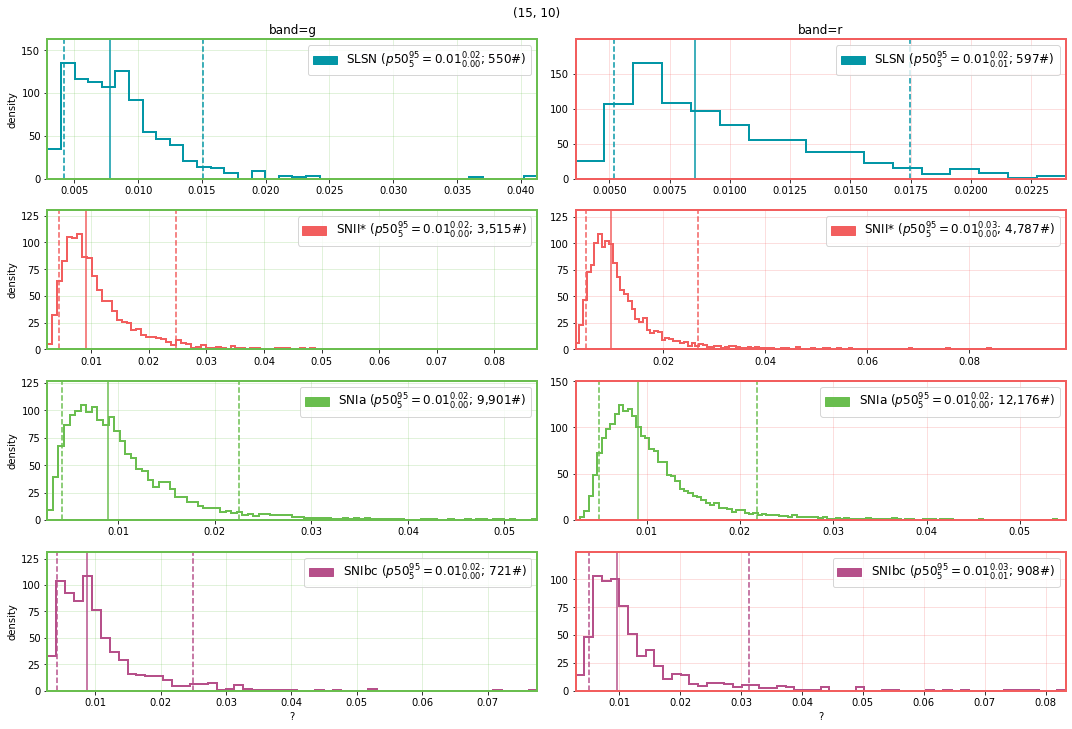

In [5]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_sigma_distribution

plot_sigma_distribution(lcdataset, '0@raw_training')

In [6]:
%load_ext autoreload
%autoreload 2

for kf in lcdataset.kfolds:
    for ks,set_name in enumerate([f'{kf}@raw_training', f'{kf}@raw_val', f'{kf}@raw_test']):
        lcdataset.sigma_clipping(set_name, set_name.replace('raw_',''),
            sigma_n=1,
            sigma_m=5, # 1, 3, 5
            apply_lower_bound=False,
            verbose=1,
            )

print(lcdataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LCDataset:
[outliers; samples 4]
(.) obs_samples=289; min_len=14; max_dur=408.0[days]; dur(p50)=222.1[days]; cadence(p50)=0.9[days]
(g) obs_samples=144; min_len=6; tmax=44.923828125; max_dur=408.0 [days]; dur(p50)=222.0 [days]; cadence(p50)=1.9 [days]
(r) obs_samples=145; min_len=8; tmax=212.09375; max_dur=376.0 [days]; dur(p50)=220.4 [days]; cadence(p50)=2.0 [days]
   |██      | SLSN - 1/4 (25.00%)
   |████    | SNII* - 2/4 (50.00%)
   |██      | SNIa - 1/4 (25.00%)
   |        | SNIbc - 0/4 (0.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint; samples 0]
empty lcset
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw; samples 1,994]
(.) obs_samples=54,685; min_len=6; max_dur=538.8[days]; dur(p50)=52.9[days]; cadence(p50)=1.0[days]
(g) obs_samples=24,132; min_len=0; tmax=10.99609375;

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


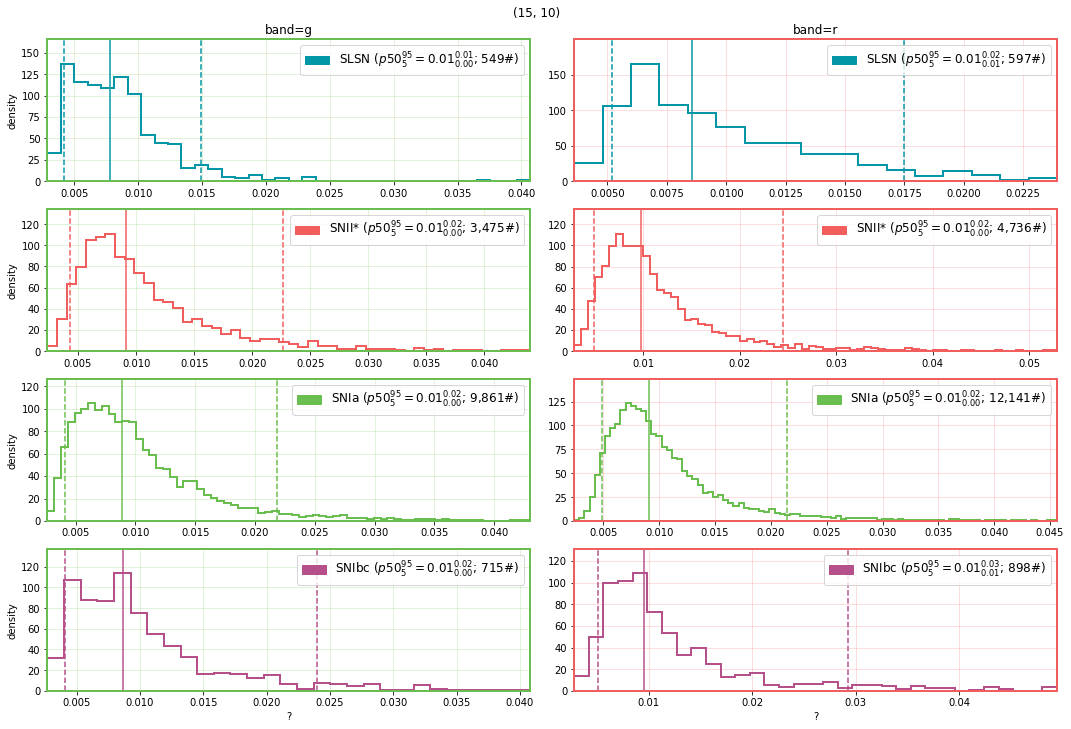

In [7]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_sigma_distribution

plot_sigma_distribution(lcdataset, '0@training')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


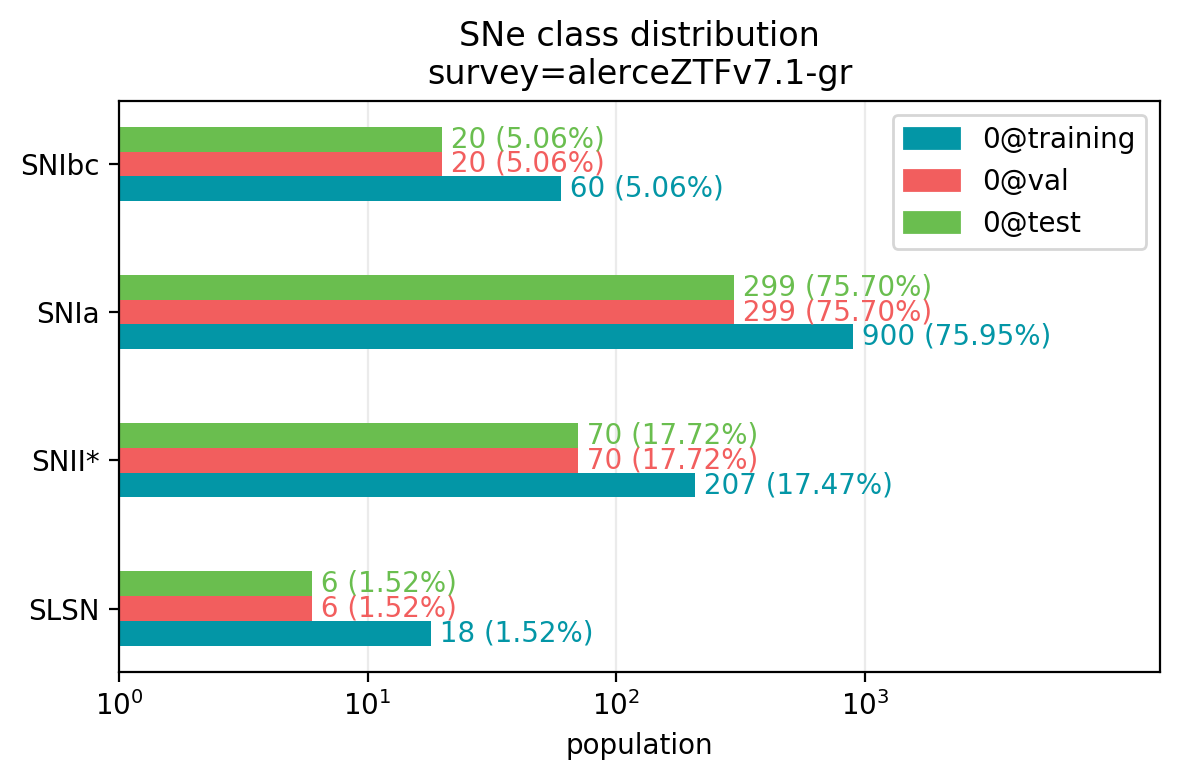

In [8]:
%load_ext autoreload
%autoreload 2
from lchandler.plots.distrs import plot_class_distribution

plot_class_distribution(lcdataset, ['0@training', '0@val', '0@test'])

In [9]:
from fuzzytools.files import load_pickle, save_pickle
from lchandler import _C

new_cfilename = f'{cfilename}'
save_filedir = f'{root_folder}/{new_cfilename}.{_C.EXT_SPLIT_LIGHTCURVE}'
save_pickle(save_filedir, lcdataset)

In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
from fuzzytools.progress_bars import ProgressBar
from fuzzytools.files import load_pickle, save_pickle
from fuzzytools.files import get_dict_from_filedir

filedir = f'../../surveys-save/wiib/survey=alerceZTFv7.1~bands=gr~mode=onlySNe.splcds'
filedict = get_dict_from_filedir(filedir)
root_folder = filedict['_rootdir']
cfilename = filedict['_cfilename']
survey = filedict['survey']
lcdataset2 = load_pickle(filedir)
print(lcdataset2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
LCDataset:
[outliers; samples 4]
(.) obs_samples=289; min_len=14; max_dur=408.0[days]; dur(p50)=222.1[days]; cadence(p50)=0.9[days]
(g) obs_samples=144; min_len=6; tmax=44.923828125; max_dur=408.0 [days]; dur(p50)=222.0 [days]; cadence(p50)=1.9 [days]
(r) obs_samples=145; min_len=8; tmax=212.09375; max_dur=376.0 [days]; dur(p50)=220.4 [days]; cadence(p50)=2.0 [days]
   |██      | SLSN - 1/4 (25.00%)
   |████    | SNIIbn - 2/4 (50.00%)
   |██      | SNIa - 1/4 (25.00%)
   |        | SNIbc - 0/4 (0.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint; samples 0]
empty lcset
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw; samples 1,994]
(.) obs_samples=54,685; min_len=6; max_dur=538.8[days]; dur(p50)=52.9[days]; cadence(p50)=1.0[days]
(g) obs_samples=24,132; min_len=0; tmax=10.99609375

In [11]:
['ZTF18abojpnr', 'ZTF19aaugupw', 'ZTF19aawethv', 'ZTF18acbzoyh', 'ZTF18acqxyiq', 'ZTF18acrcyqw', 'ZTF19aadpqnb', 'ZTF19aaknate', 'ZTF19aalzvnu', 'ZTF19abqykei', 'ZTF19abqmsnk', 'ZTF19acyjjni', 'ZTF19aczmnqy', 'ZTF19aaejtof', 'ZTF20aawefgx', 'ZTF20aaxhzhc']

['ZTF18abojpnr',
 'ZTF19aaugupw',
 'ZTF19aawethv',
 'ZTF18acbzoyh',
 'ZTF18acqxyiq',
 'ZTF18acrcyqw',
 'ZTF19aadpqnb',
 'ZTF19aaknate',
 'ZTF19aalzvnu',
 'ZTF19abqykei',
 'ZTF19abqmsnk',
 'ZTF19acyjjni',
 'ZTF19aczmnqy',
 'ZTF19aaejtof',
 'ZTF20aawefgx',
 'ZTF20aaxhzhc']

In [14]:
lcdataset['1@test'].get_lcobj_names()

['ZTF20aahbfmf',
 'ZTF19abpbopt',
 'ZTF19aalvdeu',
 'ZTF19aarphwc',
 'ZTF18abxbmqh',
 'ZTF19aamrais',
 'ZTF20aawxpru',
 'ZTF19aayjhpg',
 'ZTF19aamohrk',
 'ZTF19abcejsg',
 'ZTF19acgbkzr',
 'ZTF19aapafqd',
 'ZTF20aamttiw',
 'ZTF19aawgxdn',
 'ZTF18ablqehq',
 'ZTF20aawijco',
 'ZTF18abuicad',
 'ZTF19abgiwkt',
 'ZTF19abcejfo',
 'ZTF19aavjzwm',
 'ZTF18acrflch',
 'ZTF18abdfwcy',
 'ZTF19abpnrrf',
 'ZTF20aazhxsw',
 'ZTF18abzrgim',
 'ZTF20aadyqdh',
 'ZTF18acqsqrg',
 'ZTF19aaladlt',
 'ZTF18acbwaxk',
 'ZTF18acbvhit',
 'ZTF19aajwkbb',
 'ZTF19aauvbqv',
 'ZTF19abgndlf',
 'ZTF18abeajml',
 'ZTF20aaurgib',
 'ZTF18abrlljc',
 'ZTF19aamggmk',
 'ZTF19abqyoxt',
 'ZTF19adakmbh',
 'ZTF19ablfdwt',
 'ZTF19aaqdkrm',
 'ZTF19aanfqug',
 'ZTF19abqwsuf',
 'ZTF18accbwow',
 'ZTF19abdviwl',
 'ZTF18acrtvmm',
 'ZTF20aaiovoy',
 'ZTF19aakjcxs',
 'ZTF18acqsroy',
 'ZTF18abxbhov',
 'ZTF19aauqwna',
 'ZTF18abimhfu',
 'ZTF19aaydpiq',
 'ZTF19aapbfot',
 'ZTF19aamowaf',
 'ZTF20aadxrvb',
 'ZTF19abiietd',
 'ZTF19aamvape',
 'ZTF19ablojrw

In [15]:
lcdataset2['1@test'].get_lcobj_names()

['ZTF20aahbfmf',
 'ZTF19abpbopt',
 'ZTF19aalvdeu',
 'ZTF19aarphwc',
 'ZTF18abxbmqh',
 'ZTF19aamrais',
 'ZTF20aawxpru',
 'ZTF19aayjhpg',
 'ZTF19aamohrk',
 'ZTF19abqmsnk',
 'ZTF19abcejsg',
 'ZTF19acgbkzr',
 'ZTF19aapafqd',
 'ZTF20aamttiw',
 'ZTF19aawgxdn',
 'ZTF18ablqehq',
 'ZTF20aawijco',
 'ZTF18abuicad',
 'ZTF19abgiwkt',
 'ZTF19aawethv',
 'ZTF19abcejfo',
 'ZTF19aavjzwm',
 'ZTF18acrflch',
 'ZTF18abdfwcy',
 'ZTF19abpnrrf',
 'ZTF20aazhxsw',
 'ZTF18abzrgim',
 'ZTF20aadyqdh',
 'ZTF18acqsqrg',
 'ZTF19aaladlt',
 'ZTF18acbwaxk',
 'ZTF18acbzoyh',
 'ZTF18acbvhit',
 'ZTF19aajwkbb',
 'ZTF19aauvbqv',
 'ZTF19abgndlf',
 'ZTF18abeajml',
 'ZTF19aalzvnu',
 'ZTF20aaurgib',
 'ZTF18abrlljc',
 'ZTF19aamggmk',
 'ZTF19abqyoxt',
 'ZTF19adakmbh',
 'ZTF19ablfdwt',
 'ZTF19aaqdkrm',
 'ZTF19aanfqug',
 'ZTF19abqwsuf',
 'ZTF18accbwow',
 'ZTF19abdviwl',
 'ZTF18acrtvmm',
 'ZTF20aaiovoy',
 'ZTF19aakjcxs',
 'ZTF18acqsroy',
 'ZTF18abxbhov',
 'ZTF19aauqwna',
 'ZTF18abimhfu',
 'ZTF19aaydpiq',
 'ZTF19aapbfot',
 'ZTF19aamowaf

In [32]:
kf = 4
l1 = lcdataset[f'{kf}@test'].get_lcobj_names()
l2 = lcdataset2[f'{kf}@test'].get_lcobj_names()
intersection = list(set(l1).intersection(set(l2)))
print(len(l1))
print(len(l2))
print(len(intersection))

395
398
393
